<a href="https://colab.research.google.com/github/AabidMK/RealtyAI_Infosys_Internship_Aug2025/blob/Kalluri_Gayathri/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("State_time_series.csv")

In [ ]:
print(f"Date column dtype: {df['Date'].dtype}")
print(f"First few dates: {df['Date'].head().tolist()}")

Date column dtype: object
First few dates: ['1996-04-30', '1996-04-30', '1996-04-30', '1996-04-30', '1996-04-30']


In [ ]:
#Convert Date column to datetime
if df['Date'].dtype == 'object':
    df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Creating dataframe with Date, RegionName, and ZHVI_AllHomes
multi_df = df[['Date', 'RegionName', 'ZHVI_AllHomes']].copy()
print(f"DataFrame shape: {multi_df.shape}")
print(f"Missing values in ZHVI_AllHomes: {multi_df['ZHVI_AllHomes'].isnull().sum()}")

DataFrame shape: (13212, 3)
Missing values in ZHVI_AllHomes: 774


In [ ]:
# Handle missing values
missing_by_region = multi_df.groupby('RegionName')['ZHVI_AllHomes'].apply(lambda x: x.isnull().sum())
print("Missing values by region:")
print(missing_by_region[missing_by_region > 0])

Missing values by region:
RegionName
Alaska                 10
DistrictofColumbia     10
Kansas                148
Louisiana             261
NewYork               136
Texas                  10
UnitedStates           95
Vermont                88
Wisconsin              16
Name: ZHVI_AllHomes, dtype: int64


In [ ]:
zhvi_cleaned = multi_df.copy()

# Linear interpolation for missing values
zhvi_cleaned['ZHVI_AllHomes_interpolated'] = zhvi_cleaned.groupby('RegionName')['ZHVI_AllHomes'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both')
)

print("After linear interpolation:")
print(zhvi_cleaned[['RegionName', 'ZHVI_AllHomes', 'ZHVI_AllHomes_interpolated']].head(10))
print(f"Missing values after interpolation: {zhvi_cleaned['ZHVI_AllHomes_interpolated'].isnull().sum()}")


After linear interpolation:
    RegionName  ZHVI_AllHomes  ZHVI_AllHomes_interpolated
0      Alabama        79500.0                     79500.0
1      Arizona       103600.0                    103600.0
2     Arkansas        64400.0                     64400.0
3   California       157900.0                    157900.0
4     Colorado       128100.0                    128100.0
5  Connecticut       132000.0                    132000.0
6     Delaware       106800.0                    106800.0
7      Florida        86300.0                     86300.0
8      Georgia        92000.0                     92000.0
9       Hawaii       227400.0                    227400.0
Missing values after interpolation: 356


In [ ]:
# Handle outliers using rolling median
window_size = 5
rolling_median = zhvi_cleaned.groupby('RegionName')['ZHVI_AllHomes_interpolated'].transform(
    lambda x: x.rolling(window=window_size, center=True, min_periods=1).median()
)

threshold = 3
diff = (zhvi_cleaned['ZHVI_AllHomes_interpolated'] - rolling_median).abs()
mad = diff.groupby(zhvi_cleaned['RegionName']).transform(lambda x: x.median())

zhvi_cleaned['ZHVI_AllHomes_Cleaned'] = zhvi_cleaned['ZHVI_AllHomes_interpolated']
zhvi_cleaned.loc[diff > threshold * mad, 'ZHVI_AllHomes_Cleaned'] = rolling_median

In [ ]:
# Count outliers
original_values = zhvi_cleaned['ZHVI_AllHomes_interpolated']
cleaned_values = zhvi_cleaned['ZHVI_AllHomes_Cleaned']
outliers_count = (original_values != cleaned_values).sum()

print(f"Number of outliers detected and corrected: {outliers_count}")

Number of outliers detected and corrected: 1967


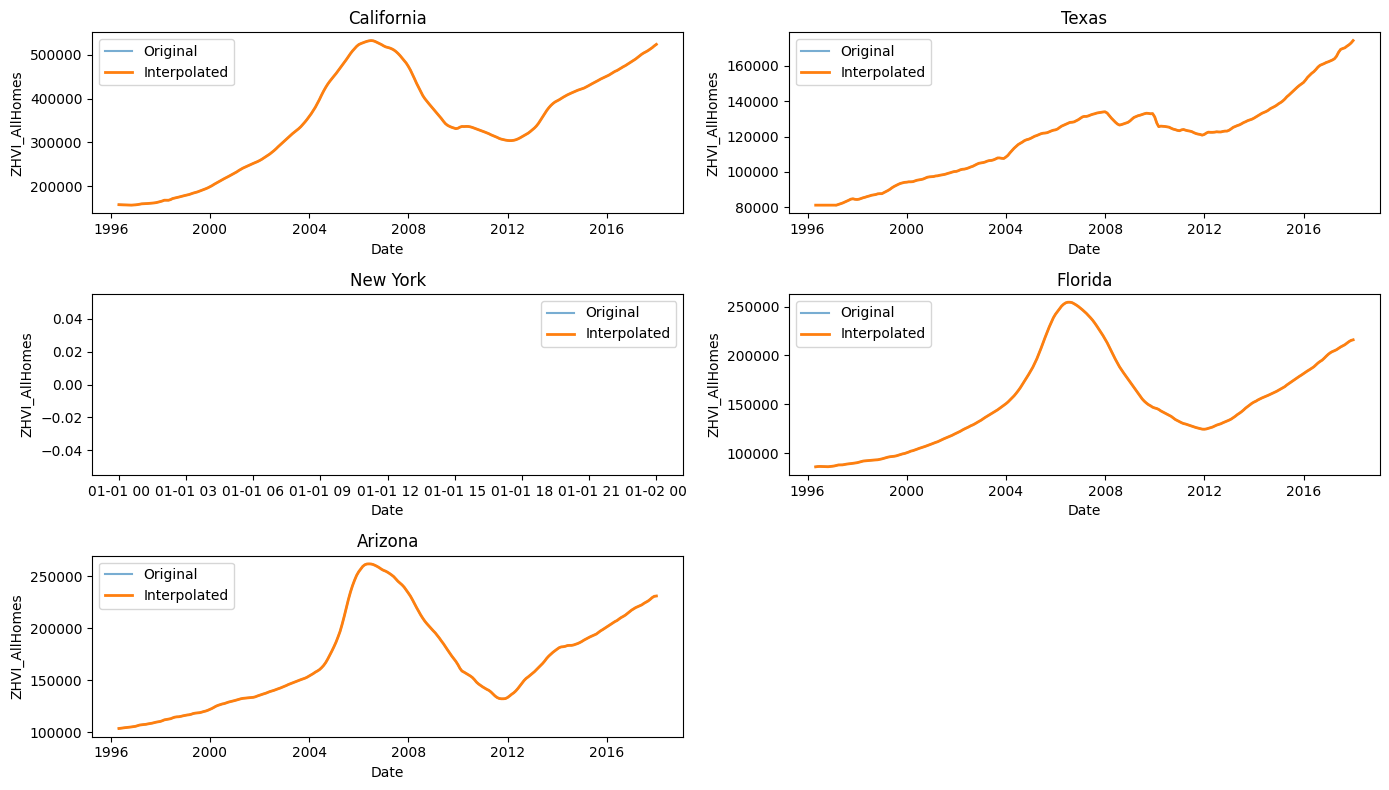

In [ ]:
import matplotlib.pyplot as plt
sample_regions = ["California", "Texas", "New York", "Florida", "Arizona"]

plt.figure(figsize=(14, 8))
for i, region in enumerate(sample_regions, 1):
    plt.subplot(3, 2, i)
    region_data = zhvi_cleaned[zhvi_cleaned['RegionName'] == region]  # use cleaned df
    plt.plot(region_data['Date'], region_data['ZHVI_AllHomes'], label="Original", alpha=0.6)
    plt.plot(region_data['Date'], region_data['ZHVI_AllHomes_interpolated'], label="Interpolated", linewidth=2)
    plt.title(region)
    plt.xlabel("Date")
    plt.ylabel("ZHVI_AllHomes")
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
!pip install prophet tqdm --quiet
from tqdm import tqdm

# Prophet import (works for both package names)
try:
    from prophet import Prophet
except:
    from fbprophet import Prophet


In [ ]:
# Train Prophet on ALL regions
from tqdm import tqdm

all_forecasts = {}  # store forecasts per region
periods = 24        # forecast horizon (months)
freq = "MS"         # monthly start

regions = multi_df['RegionName'].unique()

# pick best target column available
if "ZHVI_AllHomes_Cleaned" in multi_df.columns:
    target_col = "ZHVI_AllHomes_Cleaned"
elif "ZHVI_AllHomes_interpolated" in multi_df.columns:
    target_col = "ZHVI_AllHomes_interpolated"
else:
    target_col = "ZHVI_AllHomes"

print(f"Using target column: {target_col}")

for region in tqdm(regions):
    region_df = multi_df[multi_df['RegionName'] == region][['Date', target_col]].dropna()
    region_df = region_df.rename(columns={'Date': 'ds', target_col: 'y'})
    region_df = region_df.sort_values('ds')

    if len(region_df) < 12:  # skip if too few data points
        continue

    # Fit model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(region_df)

    # Future dataframe
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)

    all_forecasts[region] = forecast



Using target column: ZHVI_AllHomes


  0%|          | 0/52 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpck2fushy/308si11h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpck2fushy/rio4eyi9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99248', 'data', 'file=/tmp/tmpck2fushy/308si11h.json', 'init=/tmp/tmpck2fushy/rio4eyi9.json', 'output', 'file=/tmp/tmpck2fushy/prophet_model3rpofbo4/prophet_model-20251006150232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:02:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:02:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  2%|▏         | 1/52 [00:02<02:16,  2.67s/it]DEBUG:cmdstanpy:input tempfile: /tmp/tmpck2fushy/05c2b974.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpck2fushy/ymivti7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmds

In [ ]:
# Save forecasts into one CSV
all_results = []
for region, forecast in all_forecasts.items():
    f = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    f['RegionName'] = region
    all_results.append(f)

combined_forecasts = pd.concat(all_results)
combined_forecasts.to_csv("all_region_forecasts.csv", index=False)

from google.colab import files
files.download("all_region_forecasts.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

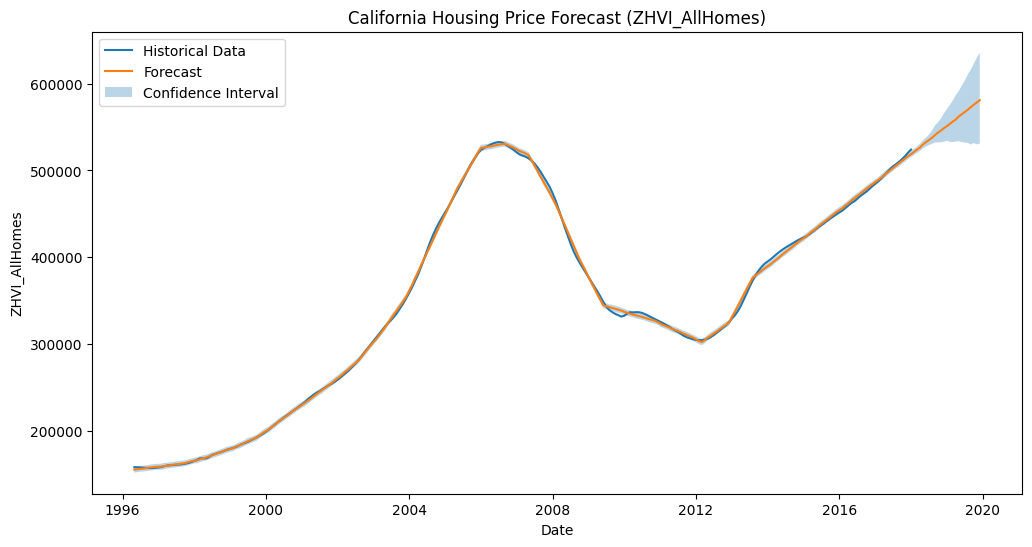

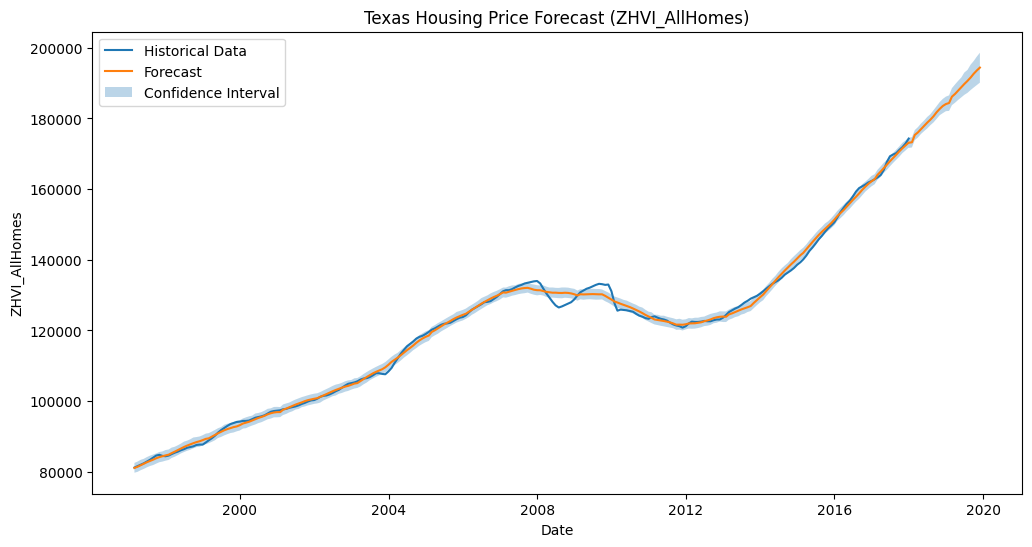

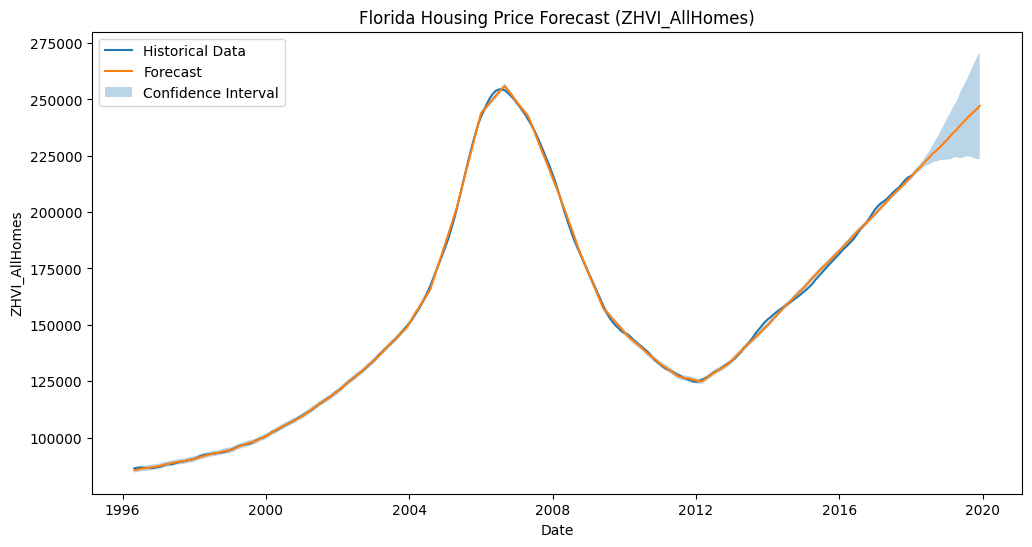

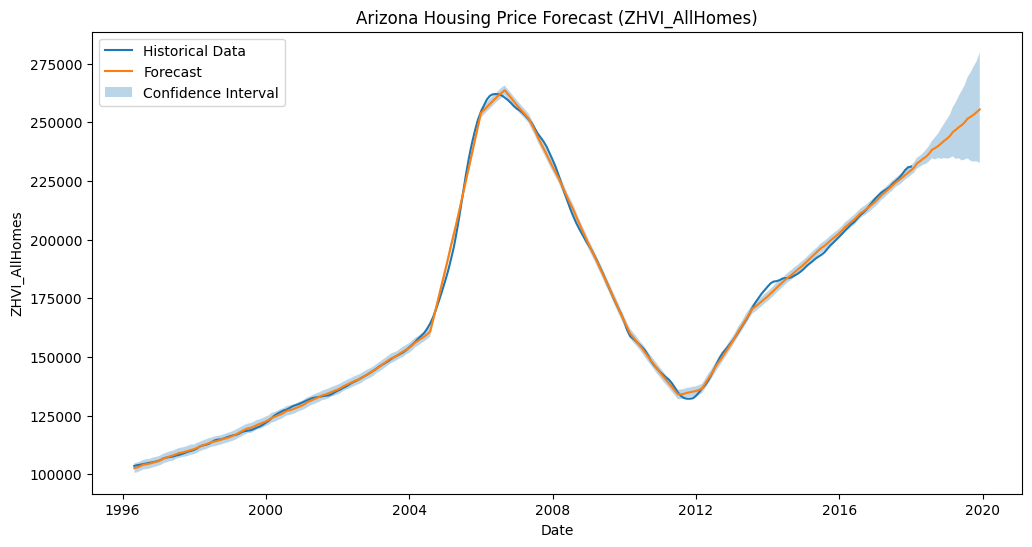

In [ ]:
for region in sample_regions:
    if region in all_forecasts:
        forecast = all_forecasts[region]

        # Use original ZHVI_AllHomes if Cleaned column not present
        region_df = multi_df[multi_df['RegionName'] == region][['Date','ZHVI_AllHomes']]
        region_df = region_df.rename(columns={'Date':'ds','ZHVI_AllHomes':'y'})

        plt.figure(figsize=(12,6))
        plt.plot(region_df['ds'], region_df['y'], label="Historical Data")
        plt.plot(forecast['ds'], forecast['yhat'], label="Forecast")
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3, label="Confidence Interval")
        plt.title(f"{region} Housing Price Forecast (ZHVI_AllHomes)")
        plt.xlabel("Date")
        plt.ylabel("ZHVI_AllHomes")
        plt.legend()
        plt.show()

